In [4]:
import pickle,h5py,os,keras,json, os, argparse, imp
import tensorflow as tf
import numpy as np

In [2]:
%load_ext autoreload
%autoreload 2
import utils as ut

In [3]:
# intializations 
path_to_data = # Data path of the created dictionary
filename = 'All_activity_instances_data.h5'

In [5]:
# Loading the osurce and target classes
total_Activities = 33
pickle_out = open('source_activities.pkl',"rb")
src_act_array = pickle.load(pickle_out)
trg_act_array = np.arange(total_Activities)[~np.isin(np.arange(total_Activities),src_act_array)]

In [25]:
activities_decribe = ["A1: Walking","A2: Jogging","A3: Running","A4: Jump up","A5: Jump front & back","A6: Jump sideways","A7: Jump leg/arms open/closed","A8: Jump rope","A9: Trunk twist (arms outstretched)","A10: Trunk twist (elbows bent)","A11: Waist bends forward","A12: Waist rotation","A13: Waist bends (reach foot with opposite hand)","A14: Reach heels backwards","A15: Lateral bend (10_ to the left + 10_ to the right)","A16: Lateral bend with arm up (10_ to the left + 10_ to the right)","A17: Repetitive forward stretching","A18: Upper trunk and lower body opposite twist","A19: Lateral elevation of arms","A20: Frontal elevation of arms","A21: Frontal hand claps","A22: Frontal crossing of arms","A23: Shoulders high-amplitude rotation","A24: Shoulders low-amplitude rotation","A25: Arms inner rotation","A26: Knees (alternating) to the breast","A27: Heels (alternating) to the backside","A28: Knees bending (crouching)","A29: Knees (alternating) bending forward","A30: Rotation on the knees","A31: Rowing","A32: Elliptical bike","A33: Cycling"]

In [29]:
print("Target Acitivities")
for i in range(trg_act_array.shape[0]):
    print(activities_decribe[trg_act_array[i]])
print("Source Acitivities")
for i in range(src_act_array.shape[0]):
    print(activities_decribe[src_act_array[i]])

Target Acitivities
A12: Waist rotation
A14: Reach heels backwards
A16: Lateral bend with arm up (10_ to the left + 10_ to the right)
A26: Knees (alternating) to the breast
A27: Heels (alternating) to the backside
A30: Rotation on the knees
A33: Cycling
Source Acitivities
A20: Frontal elevation of arms
A22: Frontal crossing of arms
A28: Knees bending (crouching)
A3: Running
A15: Lateral bend (10_ to the left + 10_ to the right)
A31: Rowing
A19: Lateral elevation of arms
A9: Trunk twist (arms outstretched)
A4: Jump up
A11: Waist bends forward
A5: Jump front & back
A18: Upper trunk and lower body opposite twist
A10: Trunk twist (elbows bent)
A2: Jogging
A21: Frontal hand claps
A6: Jump sideways
A7: Jump leg/arms open/closed
A23: Shoulders high-amplitude rotation
A17: Repetitive forward stretching
A24: Shoulders low-amplitude rotation
A8: Jump rope
A25: Arms inner rotation
A29: Knees (alternating) bending forward
A1: Walking
A13: Waist bends (reach foot with opposite hand)
A32: Elliptical 

Loading the target supp and test indices

In [6]:
pickle_out = open('Indices_trg_Test_supp.pkl',"rb")
temp = pickle.load(pickle_out) # indices of validation and test set
pickle_out.close()
indices_array_test,indices_array_supp,new_labels_test,new_labels_supp = temp[0],temp[1],temp[2],temp[3]

Loading the source indices

In [7]:
pickle_out = open('Indices_Train_Val.pkl',"rb")
temp = pickle.load(pickle_out) # indices of validation and test set
pickle_out.close()
# indices_array_train = temp[0]
indices_array_Val = temp[1]
# new_labels_train = temp[2]
new_labels_Val = temp[3]

Making the validation data for source class for sample-wise and class-wise stuff later

In [8]:
data_file = h5py.File(os.path.join(path_to_data,filename), 'r') 
X_data = data_file['X']
X_Val = np.zeros((indices_array_Val.shape[0],X_data.shape[1],X_data.shape[2]))
for i in range(indices_array_Val.shape[0]):
    X_Val[i,:,:] = X_data[indices_array_Val[i],:,:]
y_Val = ut.convert_one_hot(new_labels_Val)

Getting the target and support set

In [9]:
X_supp = np.zeros((indices_array_supp.shape[0],X_data.shape[1],X_data.shape[2]))

for i in range(indices_array_supp.shape[0]):
    X_supp[i,:,:] = X_data[indices_array_supp[i],:,:]
y_supp = ut.convert_one_hot(new_labels_supp)

 Model loading 

In [33]:
from keras.models import model_from_json
from keras.backend.tensorflow_backend import set_session


In [34]:

config = tf.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.Session(config=config)
set_session(sess)



In [85]:
modelPath = "./models/"
modelName = "Stacked_LSTM_classifier"
with open(os.path.join(modelPath, modelName+'.json'), 'r') as f:
    source_model = keras.models.model_from_json(f.read())

In [86]:
source_model.load_weights(os.path.join(modelPath, modelName+'2.wgt'))
ad =keras.optimizers.Adam(lr = 0.01)
source_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=ad, metrics=['acc'])

In [37]:
# Checking if the laoded weights actually work on the validation set 
source_model.evaluate(X_Val,y_Val)

520/520 [==============================] - 3s 6ms/step


[0.06823588634053102, 0.9846153855323792]

35

Sample-wise and Classwise Relavence

In [38]:
num_features = source_model.layers[-3].predict(X_Val[0:1,:,:]).shape[1]
samples_trg = indices_array_supp.shape[0]
samples_src = X_Val.shape[0]

In [39]:
features_src = source_model.layers[-3].predict(X_Val)
features_trg = source_model.layers[-3].predict(X_supp)
f_src_tilda = features_src/(np.linalg.norm(features_src,2,axis = 1))[:,None]
f_trg_tilda = features_trg/(np.linalg.norm(features_trg,2,axis = 1))[:,None]

In [40]:
# sample-wise
A = np.zeros((samples_src,samples_trg))
for i in range(samples_src):
    for j in range(samples_trg):
        A[i,j] = np.exp(np.dot(f_src_tilda[i,:],f_trg_tilda[j,:]))


In [41]:
# Classwise
Classwise_weights = ut.classwise_weights(src_act_array,trg_act_array,new_labels_Val,new_labels_supp,A)


In [87]:
## Normalization
# W = ut.soft_normalization(Classwise_weights)
W = ut.hard_normalization(Classwise_weights)

In [74]:
source_model.layers[-2].get_weights()[0].shape

(40, 26)

Setting up the knowledge transfer model

In [88]:
# from keras.models import Sequential
# model = Sequential()
# model.add()
# merged = keras.layers.Concatenate([merged,keras.layers.Activation("softmax")])
W_trg = keras.layers.Dense(W.shape[1],use_bias= False)(source_model.layers[-2].output)
final_out = keras.layers.Activation('softmax')(W_trg)
Final_model = keras.Model(inputs = source_model.inputs,outputs = final_out)

In [89]:
Final_model.layers[-2].set_weights([W])

In [45]:
Final_model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          (None, 250, 117)          0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 40)                226616    
_________________________________________________________________
dense_9 (Dense)              (None, 26)                1040      
_________________________________________________________________
dense_1 (Dense)              (None, 7)                 182       
_________________________________________________________________
activation_1 (Activation)    (None, 7)                 0         
Total params: 227,838
Trainable params: 227,838
Non-trainable params: 0
_________________________________________________________________


In [90]:
ad =keras.optimizers.Adam(lr = 0.01)
Final_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=ad, metrics=['acc'])
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=os.path.join(modelPath,modelName+'target.wgt'), 
                                verbose=1, 
                                save_best_only=True,monitor = 'val_acc')

In [148]:
# Setting up the number of shots
number_shots = 5
# if(shots == 1):
unqiue_labels_supp = np.unique(new_labels_supp)
final_indices = np.zeros(unqiue_labels_supp.shape[0]*number_shots)
count = 0
for item in unqiue_labels_supp:
    indices = np.where(np.array(new_labels_supp) == item)
    index = np.random.choice(indices[0],size = number_shots,replace = False)
    final_indices[count:count+number_shots] = index[0:]
    count = count+number_shots
#     print(indices, index)
final_indices = final_indices.astype(int)

In [91]:
Final_model.fit(X_supp[final_indices,:,:],y_supp[final_indices,:],callbacks=[checkpointer],batch_size = 64,epochs=20, verbose=1,
                    shuffle = "batch",validation_data = (X_supp[final_indices,:,:],y_supp[final_indices,:]))

Train on 7 samples, validate on 7 samples
Epoch 1/20
7/7 [==============================] - 1s 191ms/step - loss: 8.7447 - acc: 0.2857 - val_loss: 2.4201 - val_acc: 0.4286

Epoch 00001: val_acc improved from -inf to 0.42857, saving model to ./models/Stacked_LSTM_classifiertarget.wgt
Epoch 2/20
7/7 [==============================] - 1s 75ms/step - loss: 2.6008 - acc: 0.4286 - val_loss: 1.2060 - val_acc: 0.7143

Epoch 00002: val_acc improved from 0.42857 to 0.71429, saving model to ./models/Stacked_LSTM_classifiertarget.wgt
Epoch 3/20
7/7 [==============================] - 1s 73ms/step - loss: 1.9227 - acc: 0.5714 - val_loss: 0.6286 - val_acc: 0.8571

Epoch 00003: val_acc improved from 0.71429 to 0.85714, saving model to ./models/Stacked_LSTM_classifiertarget.wgt
Epoch 4/20
7/7 [==============================] - 1s 74ms/step - loss: 0.6752 - acc: 0.7143 - val_loss: 0.4410 - val_acc: 1.0000

Epoch 00004: val_acc improved from 0.85714 to 1.00000, saving model to ./models/Stacked_LSTM_class

In [51]:
X_test = np.zeros((indices_array_test.shape[0],X_data.shape[1],X_data.shape[2]))

for i in range(indices_array_test.shape[0]):
    X_test[i,:,:] = X_data[indices_array_test[i],:,:]
y_test = ut.convert_one_hot(new_labels_test)

In [92]:
Final_model.load_weights(os.path.join(modelPath, modelName+'target.wgt'))
ad =keras.optimizers.Adam(lr = 0.01)
Final_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=ad, metrics=['acc'])
Final_model.evaluate(X_test,y_test)

2636/2636 [==============================] - 16s 6ms/step


[0.9516286665463484, 0.6122913360595703]

In [93]:
out = Final_model.predict(X_test)

In [83]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
from matplotlib import pyplot as plt

Text(0.5, 1.0, 'Hard Normalization 1-shot')

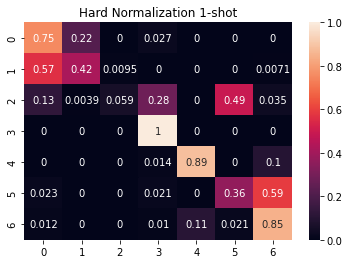

In [94]:

conf = confusion_matrix(y_test.argmax(axis=1), out.argmax(axis=1),normalize='true')
sn.heatmap(conf, annot=True)
plt.title("Hard Normalization 1-shot")

Source Features and then Softmax


In [114]:
with open(os.path.join(modelPath, modelName+'.json'), 'r') as f:
    source_model = keras.models.model_from_json(f.read())
source_model.load_weights(os.path.join(modelPath, modelName+'2.wgt'))
W_trg2 = keras.layers.Dense(W.shape[1],use_bias= False)(source_model.layers[-2].output)
final_out = keras.layers.Activation('softmax')(W_trg2)
Final_model = keras.Model(inputs = source_model.inputs,outputs = final_out)
Final_model.summary()

Model: "model_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
digits (InputLayer)          (None, 250, 117)          0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 40)                226616    
_________________________________________________________________
dense_9 (Dense)              (None, 26)                1040      
_________________________________________________________________
dense_10 (Dense)             (None, 7)                 182       
_________________________________________________________________
activation_10 (Activation)   (None, 7)                 0         
Total params: 227,838
Trainable params: 227,838
Non-trainable params: 0
_________________________________________________________________


In [115]:
ad =keras.optimizers.Adam(lr = 0.01)
Final_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=ad, metrics=['acc'])
from keras.callbacks import ModelCheckpoint
checkpointer = ModelCheckpoint(filepath=os.path.join(modelPath,modelName+'target.wgt'), 
                                verbose=1, 
                                save_best_only=True,monitor = 'val_acc')

In [116]:
Final_model.fit(X_supp[final_indices,:,:],y_supp[final_indices,:],batch_size = 64,epochs=20, verbose=1,
                    shuffle = "batch",callbacks=[checkpointer],validation_data = (X_supp[final_indices,:,:],y_supp[final_indices,:]))

Train on 7 samples, validate on 7 samples
Epoch 1/20
7/7 [==============================] - 2s 233ms/step - loss: 1.9108 - acc: 0.1429 - val_loss: 1.0992 - val_acc: 0.8571

Epoch 00001: val_acc improved from -inf to 0.85714, saving model to ./models/Stacked_LSTM_classifiertarget.wgt
Epoch 2/20
7/7 [==============================] - 1s 74ms/step - loss: 1.5561 - acc: 0.4286 - val_loss: 0.6116 - val_acc: 0.8571

Epoch 00002: val_acc did not improve from 0.85714
Epoch 3/20
7/7 [==============================] - 1s 77ms/step - loss: 1.1636 - acc: 0.7143 - val_loss: 1.4317 - val_acc: 0.5714

Epoch 00003: val_acc did not improve from 0.85714
Epoch 4/20
7/7 [==============================] - 1s 79ms/step - loss: 1.4620 - acc: 0.5714 - val_loss: 0.1891 - val_acc: 1.0000

Epoch 00004: val_acc improved from 0.85714 to 1.00000, saving model to ./models/Stacked_LSTM_classifiertarget.wgt
Epoch 5/20
7/7 [==============================] - 1s 75ms/step - loss: 0.4249 - acc: 1.0000 - val_loss: 0.3528 -

In [117]:
Final_model.load_weights(os.path.join(modelPath, modelName+'target.wgt'))
ad =keras.optimizers.Adam(lr = 0.01)
Final_model.compile(loss=keras.losses.CategoricalCrossentropy(), optimizer=ad, metrics=['acc'])
Final_model.evaluate(X_test,y_test)

2636/2636 [==============================] - 17s 6ms/step


[1.842982197567617, 0.48558422923088074]

Nearest Neighbor Classifier

In [242]:
f_src_tilda.T.shape

(40, 35)

In [141]:
with open(os.path.join(modelPath, modelName+'.json'), 'r') as f:
    source_model = keras.models.model_from_json(f.read())
source_model.load_weights(os.path.join(modelPath, modelName+'2.wgt'))

In [149]:
samples_trg = indices_array_test.shape[0]
samples_src = final_indices.shape[0]
features_src = source_model.layers[-3].predict(X_supp[final_indices,:,:])
features_trg = source_model.layers[-3].predict(X_test)
f_src_tilda = features_src/(np.linalg.norm(features_src,2,axis = 1))[:,None]
f_trg_tilda = features_trg/(np.linalg.norm(features_trg,2,axis = 1))[:,None]
# sample-wise
# A = np.zeros((samples_src,samples_trg))
# for i in range(samples_src):
#     for j in range(samples_trg):
#         A[i,j] = np.exp(np.dot(f_src_tilda[i,:],f_trg_tilda[j,:]))
# Classwise_weights = ut.classwise_weights(trg_act_array,trg_act_array,new_labels_supp,new_labels_test,A)
# W = ut.soft_normalization(Classwise_weights)


In [150]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=7)
neigh.fit(f_src_tilda,new_labels_supp[final_indices])

KNeighborsClassifier(n_neighbors=7)

In [151]:
res = neigh.predict_proba(f_trg_tilda)

In [152]:
uniques = np.unique(new_labels_supp[final_indices]),

In [153]:
count = 0
for i in range(res.shape[0]):
    pred = uniques[0][np.argmax(res[i,:])]
    truth = new_labels_test[i]
#     print(i,pred,truth)
    if(pred == truth):
        count= count+1
count/res.shape[0]

0.8520485584218513

In [154]:
neigh.score(f_src_tilda,new_labels_supp[final_indices])

0.8857142857142857

In [227]:
A.shape

(35, 2636)